In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
df = pd.read_csv("train.csv")
df.head()

,id_viaje,id_usuario,id_vehicle,inicio_viaje,final_viaje,lat_ini,long_ini,lat_fin,long_fin,cluster
0,11544264,14999,13184,2022-01-01T00:40:29Z,2022-01-01T01:06:06Z,40.439560,-3.710959,40.531506,-3.636610,73
1,11544318,700120,13230,2022-01-01T00:42:58Z,2022-01-01T01:01:20Z,40.420307,-3.695659,40.442307,-3.704213,8
2,11544295,697271,9893,2022-01-01T00:43:47Z,2022-01-01T01:01:22Z,40.428822,-3.703689,40.408131,-3.706030,40
3,11544349,524536,9998,2022-01-01T00:45:50Z,2022-01-01T01:09:42Z,40.425667,-3.689260,40.414787,-3.701125,7
4,11544356,697386,9789,2022-01-01T00:46:19Z,2022-01-01T01:22:58Z,40.421139,-3.696565,40.421120,-3.696330,8


In [5]:
# Convert the 'inicio_viaje' column to datetime object
df['date2'] = pd.to_datetime(df['inicio_viaje'])

# Extract the date, hour, day of the week and month from the 'date2' column
df['date'] = df['date2'].dt.date
df['hour'] = pd.DatetimeIndex(df['date2']).hour
df['dia_semana'] = df['date2'].dt.dayofweek
df['mes'] = df['date2'].dt.month

# Define a function to determine the season of the year based on the month
def get_season(mes):
    if 3 <= mes <= 5:
        return '1'  # Spring
    elif 6 <= mes <= 8:
        return '2'  # Summer
    elif 9 <= mes <= 11:
        return '3'  # Autumn
    else:
        return '4'  # Winter

# We apply the 'get_season' function to create a new 'season' column
df['season'] = df['mes'].apply(get_season)

# Show the first rows of the DataFrame with the new columns
df.head()


,id_viaje,id_usuario,id_vehicle,inicio_viaje,final_viaje,lat_ini,long_ini,lat_fin,long_fin,cluster,date2,date,hour,dia_semana,mes,season
0,11544264,14999,13184,2022-01-01T00:40:29Z,2022-01-01T01:06:06Z,40.439560,-3.710959,40.531506,-3.636610,73,2022-01-01 00:40:29+00:00,2022-01-01,0,5,1,4
1,11544318,700120,13230,2022-01-01T00:42:58Z,2022-01-01T01:01:20Z,40.420307,-3.695659,40.442307,-3.704213,8,2022-01-01 00:42:58+00:00,2022-01-01,0,5,1,4
2,11544295,697271,9893,2022-01-01T00:43:47Z,2022-01-01T01:01:22Z,40.428822,-3.703689,40.408131,-3.706030,40,2022-01-01 00:43:47+00:00,2022-01-01,0,5,1,4
3,11544349,524536,9998,2022-01-01T00:45:50Z,2022-01-01T01:09:42Z,40.425667,-3.689260,40.414787,-3.701125,7,2022-01-01 00:45:50+00:00,2022-01-01,0,5,1,4
4,11544356,697386,9789,2022-01-01T00:46:19Z,2022-01-01T01:22:58Z,40.421139,-3.696565,40.421120,-3.696330,8,2022-01-01 00:46:19+00:00,2022-01-01,0,5,1,4


In [6]:
# Group the dataframe by different columns and count the number of the group
num_viajes=df.groupby(['cluster', 'hour','dia_semana','mes','season','date'])['cluster'].count().to_frame(name = 'trips').reset_index()
num_viajes.head()

,cluster,hour,dia_semana,mes,season,date,trips
0,1,0,0,2,4,2022-02-14,1
1,1,0,0,2,4,2022-02-21,1
2,1,0,0,3,1,2022-03-28,1
3,1,0,0,4,1,2022-04-25,2
4,1,0,0,5,1,2022-05-02,1


In [7]:
# Convert specific columns to string (str) data types
num_viajes['cluster'] = num_viajes['cluster'].astype(str)
num_viajes['hour'] = num_viajes['hour'].astype(str)
num_viajes['dia_semana'] = num_viajes['dia_semana'].astype(str)
num_viajes['season'] = num_viajes['season'].astype(str)
num_viajes['date'] = num_viajes['date'].astype(str)
num_viajes['mes'] = num_viajes['mes'].astype(str)

In [8]:
num_viajes.dtypes

cluster       object
hour          object
dia_semana    object
mes           object
season        object
date          object
trips          int64
dtype: object

**Transformation of sample submission to test (real predictions)**

In [9]:
test = pd.read_csv("sample_submission.csv")
test

,Id,trips
0,72_2022-09-30_22,2.869596
1,93_2022-09-30_22,2.869596
2,36_2022-09-30_22,2.869596
3,83_2022-09-30_22,2.869596
4,92_2022-09-30_22,2.869596
...,...,...
131833,45_2023-01-01_00,2.869596
131834,59_2023-01-01_00,2.869596
131835,25_2023-01-01_00,2.869596
131836,37_2023-01-01_00,2.869596


In [10]:
# Divide 'id' column using the "_" character as a separator and expand the results into separate columns
split_test= test["Id"].str.split("_", n = 3, expand = True)
split_test

,0,1,2
0,72,2022-09-30,22
1,93,2022-09-30,22
2,36,2022-09-30,22
3,83,2022-09-30,22
4,92,2022-09-30,22
...,...,...,...
131833,45,2023-01-01,00
131834,59,2023-01-01,00
131835,25,2023-01-01,00
131836,37,2023-01-01,00


In [11]:
# Assign the resulting columns from the split to the 'test' DataFrame
test['cluster'] = split_test[0]
test['date'] = split_test[1]
test['hour'] = split_test[2]

# Convert specific columns to string (str) data types
test['date'] = pd.to_datetime(test['date'])

# Extract the weekday, month and season from the 'date' column
test['dia_semana'] = test['date'].dt.dayofweek
test['mes'] = test['date'].dt.month
test['season'] = test['mes'].apply(get_season)

#Drop the 'trips' column if it exists
test = test.drop(columns=['trips'])

# Show the last rows of the DataFrame 'test'
test


,Id,cluster,date,hour,dia_semana,mes,season
0,72_2022-09-30_22,72,2022-09-30,22,4,9,3
1,93_2022-09-30_22,93,2022-09-30,22,4,9,3
2,36_2022-09-30_22,36,2022-09-30,22,4,9,3
3,83_2022-09-30_22,83,2022-09-30,22,4,9,3
4,92_2022-09-30_22,92,2022-09-30,22,4,9,3
...,...,...,...,...,...,...,...
131833,45_2023-01-01_00,45,2023-01-01,00,6,1,4
131834,59_2023-01-01_00,59,2023-01-01,00,6,1,4
131835,25_2023-01-01_00,25,2023-01-01,00,6,1,4
131836,37_2023-01-01_00,37,2023-01-01,00,6,1,4


In [12]:
# Convert specific columns to string (str) data types
test['date']=test['date'].astype(str)
test['dia_semana']=test['dia_semana'].astype(str)
test['mes']=test['mes'].astype(str)
test.dtypes

Id            object
cluster       object
date          object
hour          object
dia_semana    object
mes           object
season        object
dtype: object

**Calculate the mean per cluster**

In [13]:
# Caluate the mean of the number of trips by cluster and hour
media_por_cluster = num_viajes.groupby(['cluster', 'hour'])['trips'].mean().to_frame(name='trips').reset_index()
media_por_cluster.head()

,cluster,hour,trips
0,1,0,2.010695
1,1,1,1.710280
2,1,10,1.703704
3,1,11,1.856383
4,1,12,2.160194


In [14]:
media_por_cluster['hour'] = media_por_cluster['hour'].astype(object)

In [15]:
# Merging the DataFrames 'test' and 'media_por_cluster' by the columns 'cluster' and 'hour'
test_media = pd.merge(test, media_por_cluster, how='left', left_on=['cluster', 'hour'], right_on=['cluster', 'hour'])

#Fill the null values in the 'trips' column with zeros
test_media['trips'] = test_media['trips'].fillna(0)


In [17]:
test_media['hour'] = test_media['hour'].astype(int)

In [18]:
num_viajes['hour'] = num_viajes['hour'].astype(int)

**WEATHER MERGING**

In [22]:
weather = pd.read_csv('weather.csv')

In [23]:
# Create a list of hours from 0 to 23
horas = list(range(24))

# Repeat each row in df2 for each hour and assign the corresponding hour
weather_expandido = pd.DataFrame()
for _, fila in weather.iterrows():
    fila_repetida = pd.DataFrame([fila] * 24)
    fila_repetida['hour'] = horas
    weather_expandido = pd.concat([weather_expandido, fila_repetida], ignore_index=True)
weather_expandido

,date,tavg,tmin,tmax,prcp,wdir,wspd,pres,hour
0,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,0
1,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,1
2,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,2
3,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,3
4,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,4
...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,19
8756,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,20
8757,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,21
8758,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,22


In [24]:
#Create a new row with the date of January 1, 2022 and the data of December 31, 2022
new_row = weather_expandido.iloc[-1].copy()
new_row['date'] = '2023-01-01'
new_row_df = pd.DataFrame([new_row])

#Add the new row to the DataFrame
weather_expandido = pd.concat([weather_expandido, new_row_df],ignore_index = True)
weather_expandido['hour'].iloc[8760] = 0

#Show the last rows of the updated DataFrame to verify the addition
weather_expandido.tail()

C:\Users\alvar\AppData\Local\Temp\ipykernel_16920\1595500720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_expandido['hour'].iloc[8760] = 0


,date,tavg,tmin,tmax,prcp,wdir,wspd,pres,hour
8756,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,20
8757,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,21
8758,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,22
8759,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,23
8760,2023-01-01,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,0


In [25]:
weather_expandido['date']

0       2022-01-01
1       2022-01-01
2       2022-01-01
3       2022-01-01
4       2022-01-01
           ...    
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
8760    2023-01-01
Name: date, Length: 8761, dtype: object

In [26]:
weather_train = weather_expandido[weather_expandido['date'] <= '2022-09-30']
weather_test = weather_expandido[weather_expandido['date'] >= '2022-09-30']

In [27]:
weather_test

,date,tavg,tmin,tmax,prcp,wdir,wspd,pres,hour
6528,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,0
6529,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,1
6530,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,2
6531,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,3
6532,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,4
...,...,...,...,...,...,...,...,...,...
8756,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,20
8757,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,21
8758,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,22
8759,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,23


In [28]:
num_viajes_weather = pd.merge(num_viajes,weather_train, on = ['date','hour'])
num_viajes_weather.sort_values(['date','hour'])

,cluster,hour,dia_semana,mes,season,date,trips,tavg,tmin,tmax,prcp,wdir,wspd,pres
363863,3,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363864,5,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363865,7,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363866,8,0,5,1,4,2022-01-01,2,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363867,10,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287390,95,21,4,9,3,2022-09-30,1,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
287391,97,21,4,9,3,2022-09-30,5,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
287392,98,21,4,9,3,2022-09-30,9,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
287393,99,21,4,9,3,2022-09-30,4,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580


In [29]:
test['hour'] = test['hour'].astype(int)

In [30]:
test = pd.merge(test,weather_test, on = ['date','hour'])
test.sort_values(['date','hour'])

,Id,cluster,date,hour,dia_semana,mes,season,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,72_2022-09-30_22,72,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
1,93_2022-09-30_22,93,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
2,36_2022-09-30_22,36,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
3,83_2022-09-30_22,83,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
4,92_2022-09-30_22,92,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131833,45_2023-01-01_00,45,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076
131834,59_2023-01-01_00,59,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076
131835,25_2023-01-01_00,25,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076
131836,37_2023-01-01_00,37,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076


**Split for metrics**

In [31]:
num_viajes_features = num_viajes_weather[['mes','season','cluster', 'hour', 'dia_semana', 'tmin','tmax','prcp','wdir','wspd', 'pres']]
num_viajes_labels = num_viajes_weather['trips']

In [32]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(num_viajes_features, num_viajes_labels, test_size = 0.25, random_state = 42)

In [33]:
test_features.sort_values(['hour'])

,mes,season,cluster,hour,dia_semana,tmin,tmax,prcp,wdir,wspd,pres
363972,4,1,86,0,5,-0.998526,-1.076572,0.147070,0.889074,3.307552,-2.471441
3676,4,1,21,0,3,-0.315441,-0.526360,0.198513,-0.994130,-0.284609,0.249441
322620,5,1,35,0,3,0.992593,1.232163,-0.341636,-0.379013,-0.284609,-0.307464
7818,5,1,85,0,5,0.803655,0.628008,-0.135865,-0.871107,-0.865693,-0.291553
362852,3,1,64,0,1,-0.940391,-1.033418,-0.341636,0.728197,0.190825,-0.116525
...,...,...,...,...,...,...,...,...,...,...,...
308191,5,1,46,23,0,0.193239,0.509335,-0.341636,0.908001,-0.337434,0.185795
386264,1,4,90,23,5,-1.405470,-0.709764,-0.341636,-1.069837,-0.311022,2.477064
385892,4,1,59,23,2,-0.867722,-0.310590,-0.341636,1.948968,-0.231783,-0.848458
316461,1,4,62,23,4,-1.216531,-0.850014,-0.341636,-1.050910,0.032347,2.206567


**Train with Split**

In [35]:
model = GradientBoostingRegressor(n_estimators=100)

model.fit(train_features, train_labels)

GradientBoostingRegressor()

In [38]:
y_pred = model.predict(test_features)

**Metrics with split**

In [39]:
test_features

,mes,season,cluster,hour,dia_semana,tmin,tmax,prcp,wdir,wspd,pres
284419,1,4,80,21,4,-1.216531,-0.850014,-0.341636,-1.050910,0.032347,2.206567
385861,2,4,94,23,2,-0.780520,-0.450840,-0.341636,-0.908960,-0.548738,0.933640
160315,2,4,77,15,3,-1.201998,-0.709764,-0.341636,-1.278030,-1.261888,1.506457
214353,9,3,13,18,1,-0.228239,0.142526,-0.341636,1.437948,-0.601564,-0.323376
306587,5,1,35,22,6,0.571115,0.994816,-0.341636,1.163511,0.137999,-1.755419
...,...,...,...,...,...,...,...,...,...,...,...
401047,2,4,46,2,4,-0.925857,-0.429263,-0.341636,-1.192860,-1.103410,0.090326
141551,5,1,69,14,3,0.701919,0.552488,-0.341636,-0.151893,-0.363847,-0.100614
62580,2,4,72,9,3,-1.071194,-0.612667,-0.341636,1.655605,-1.024171,0.774524
402133,2,4,87,5,3,-0.780520,-0.645033,-0.264472,-0.880570,-0.892106,0.392646


In [40]:
# Calculate the absolute errors
errors = abs(y_pred - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', (np.mean(errors)))

Mean Absolute Error: 1.3998904689088463


**FEATURE IMPORTANCE**

       Value     Feature
3   0.509424        hour
2   0.187223     cluster
0   0.145324         mes
4   0.077989  dia_semana
5   0.030247        tmin
7   0.013708        prcp
6   0.013304        tmax
10  0.012086        pres
8   0.005403        wdir
9   0.003372        wspd
1   0.001918      season


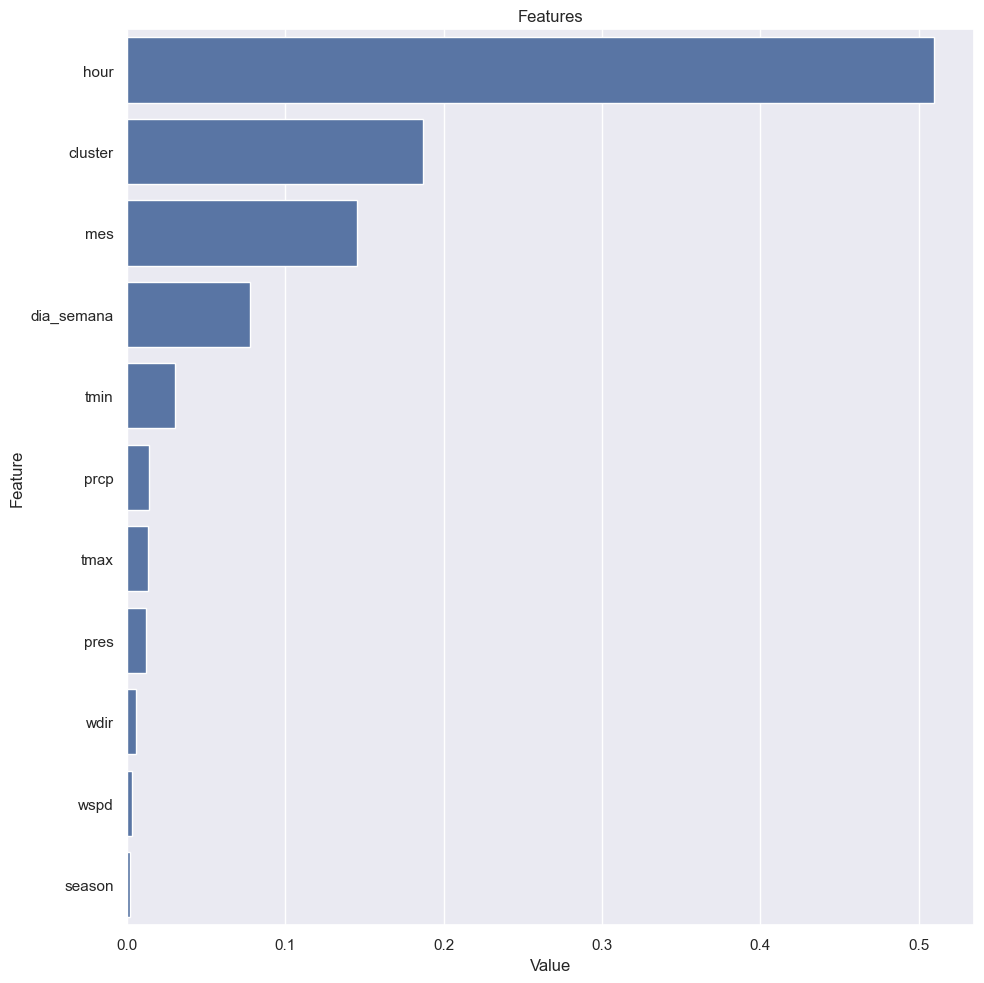

In [41]:
def plot_importance(model, features, num=len(num_viajes_features), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': num_viajes_features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(model, train_features)

**Real prediction**

In [96]:
num_viajes_weather.sort_values('date')

,cluster,hour,dia_semana,mes,season,date,trips,tavg,tmin,tmax,prcp,wdir,wspd,pres
13899,24,1,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
381279,3,18,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
337165,98,10,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
337164,82,10,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
337163,81,10,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184901,58,16,4,9,3,2022-09-30,6,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
184902,59,16,4,9,3,2022-09-30,2,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
184903,60,16,4,9,3,2022-09-30,8,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
184877,32,16,4,9,3,2022-09-30,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580


In [97]:
test

,Id,cluster,date,hour,dia_semana,mes,season,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,72_2022-09-30_22,72,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
1,93_2022-09-30_22,93,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
2,36_2022-09-30_22,36,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
3,83_2022-09-30_22,83,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
4,92_2022-09-30_22,92,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131833,45_2023-01-01_00,45,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076
131834,59_2023-01-01_00,59,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076
131835,25_2023-01-01_00,25,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076
131836,37_2023-01-01_00,37,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076


In [98]:

# Training data
X = num_viajes_weather.loc[:, ['mes','season','cluster', 'hour', 'dia_semana', 'tmin','tmax','prcp','wdir','wspd', 'pres']]  # features
y = num_viajes_weather.loc[:, 'trips']  # target

# Test data
Z = test.loc[:, ['mes','season','cluster', 'hour', 'dia_semana', 'tmin','tmax','prcp','wdir','wspd', 'pres']]


model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.2, max_depth=5)

model.fit(X, y)


pred = pd.Series(model.predict(Z), index=Z.index)

In [99]:
test['prediction']= pred
test['prediction'] = test['prediction'].fillna(0)
test

,Id,cluster,date,hour,dia_semana,mes,season,tavg,tmin,tmax,prcp,wdir,wspd,pres,prediction
0,72_2022-09-30_22,72,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,3.38
1,93_2022-09-30_22,93,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,1.77
2,36_2022-09-30_22,36,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,3.01
3,83_2022-09-30_22,83,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,1.53
4,92_2022-09-30_22,92,2022-09-30,22,4,9,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,2.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131833,45_2023-01-01_00,45,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,1.54
131834,59_2023-01-01_00,59,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,2.07
131835,25_2023-01-01_00,25,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,3.06
131836,37_2023-01-01_00,37,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,1.89


**Preparing kaggle format**

In [100]:
test.tail()

,Id,cluster,date,hour,dia_semana,mes,season,tavg,tmin,tmax,prcp,wdir,wspd,pres,prediction
131833,45_2023-01-01_00,45,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.54
131834,59_2023-01-01_00,59,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,2.07
131835,25_2023-01-01_00,25,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,3.06
131836,37_2023-01-01_00,37,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.89
131837,85_2023-01-01_00,85,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,2.12


In [101]:
test.rename(columns={'prediction': 'trips'}, inplace=True)
test = pd.DataFrame(data=test, columns=["Id", "trips"])
test

,Id,trips
0,72_2022-09-30_22,3.38
1,93_2022-09-30_22,1.77
2,36_2022-09-30_22,3.01
3,83_2022-09-30_22,1.53
4,92_2022-09-30_22,2.55
...,...,...
131833,45_2023-01-01_00,1.54
131834,59_2023-01-01_00,2.07
131835,25_2023-01-01_00,3.06
131836,37_2023-01-01_00,1.89


In [102]:
test.dtypes

Id        object
trips    float64
dtype: object

In [103]:
test.to_csv('GradientBoostRegressor.csv',index=False)